In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.layers import Bidirectional
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, SGD
import os
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# can check if you are using your GPU. 
# macOS users -> this will not work, you need to go through a great deal of pain to get it working

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU yes")
else:
    print("No GPU")

GPU yes


In [3]:
import matplotlib.pyplot as plt

In [6]:
big = pd.read_csv('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/NL_data/data_set_1/big_data.csv')
# test_set = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/test_set/processed_data.csv')

Columns (18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.


In [48]:
forecast_df = pd.read_csv('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/NL_data/forecast_set/forecast.csv')

In [8]:
# due (i suppose) to the large size of the file, there was an issue with some dummy variables, we can fix it easily

nl_df = big.copy(deep = True) # do this otherwise we have very annoying issue

nl_df['time'] = pd.to_datetime(nl_df['time'])
affected_month_columns = ['month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
df_dummies = pd.get_dummies(nl_df['time'].dt.month, prefix = 'month', dummy_na = True)
nl_df[affected_month_columns] = df_dummies[['month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0']]
nl_df.set_index('time', inplace = True)
nl_df.sort_index(inplace = True)

# maybe temporary, drop these columns they serve no purpose in LSTM
nl_df.drop(columns = ['month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'ptype', 'time.1', 'e',
       'sf', 'pev', 'fdir', 'tp', 'Unnamed: 0'], axis = 0, inplace = True)

test_2 = pd.read_csv('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/NL_data/train_set/test_part_2.csv')
test_2.set_index('time', inplace = True)
test_2.drop(columns = ['hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'], axis = 1, inplace = True)
nl_df = pd.concat((nl_df, test_2), axis = 0)

# make some extra dummies which our models will use to situate themselves in time
# nl_df['hour'] = nl_df.index.hour
# nl_df['day'] = nl_df.index.day
# nl_df = pd.get_dummies(nl_df, columns=['day', 'hour'], drop_first=True)

# can get all "major" cities df below
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]
middelburg_df = nl_df[(nl_df['latitude'] == 51.50) & (nl_df['longitude'] == 3.5)]
hertogenbosch_df = nl_df[(nl_df['latitude'] == 51.75) & (nl_df['longitude'] == 5.5)]
maastricht_df = nl_df[(nl_df['latitude'] == 51.) & (nl_df['longitude'] == 5.75)]
utrecht_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 5.)]
hague_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 4.25)]
arnhem_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 6.)]
lelystad_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 5.5)]
zwolle_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 6.)]
leeuwarden_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 5.75)]
assen_df = nl_df[(nl_df['latitude'] == 53.) & (nl_df['longitude'] == 6.5)]
groningen_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 6.5)]

ams_tr, ams_ts = ams_df.iloc[:125500], ams_df.iloc[125500:]
middelburg_tr, middelburg_ts = middelburg_df.iloc[:125500], middelburg_df.iloc[125500:]
hertogenbosch_tr, hertogenbosch_ts = hertogenbosch_df.iloc[:125500], hertogenbosch_df.iloc[125500:]
maastricht_tr, maastricht_ts = maastricht_df.iloc[:125500], maastricht_df.iloc[125500:]
utrecht_tr, utrecht_ts = utrecht_df.iloc[:125500], utrecht_df.iloc[125500:]
hague_tr, hague_ts = hague_df.iloc[:125500], hague_df.iloc[125500:]
arnhem_tr, arnhem_ts = arnhem_df.iloc[:125500], arnhem_df.iloc[125500:]
lelystad_tr, lelystad_ts = lelystad_df[:125500], lelystad_df[125500:]
zwolle_tr, zwolle_ts = zwolle_df[:125500], zwolle_df[125500:]
leeuwarden_tr, leeuwarden_ts = leeuwarden_df[:125500], leeuwarden_df[125500:]
assen_tr, assen_ts = assen_df[:125500], assen_df[125500:]
groningen_tr, groningen_ts = groningen_df.iloc[:125500], groningen_df.iloc[125500:]

In [49]:
ams_df_forecast = forecast_df[(forecast_df['latitude'] == 52.25) & (forecast_df['longitude'] == 5.)]
middelburg_df_forecast = forecast_df[(forecast_df['latitude'] == 51.50) & (forecast_df['longitude'] == 3.5)]
hertogenbosch_df_forecast = forecast_df[(forecast_df['latitude'] == 51.75) & (forecast_df['longitude'] == 5.5)]
maastricht_df_forecast = forecast_df[(forecast_df['latitude'] == 51.) & (forecast_df['longitude'] == 5.75)]
utrecht_df_forecast = forecast_df[(forecast_df['latitude'] == 52.) & (forecast_df['longitude'] == 5.)]
hague_df_forecast = forecast_df[(forecast_df['latitude'] == 52.) & (forecast_df['longitude'] == 4.25)]
arnhem_df_forecast = forecast_df[(forecast_df['latitude'] == 52.) & (forecast_df['longitude'] == 6.)]
lelystad_df_forecast = forecast_df[(forecast_df['latitude'] == 52.5) & (forecast_df['longitude'] == 5.5)]
zwolle_df_forecast = forecast_df[(forecast_df['latitude'] == 52.5) & (forecast_df['longitude'] == 6.)]
leeuwarden_df_forecast = forecast_df[(forecast_df['latitude'] == 53.25) & (forecast_df['longitude'] == 5.75)]
assen_df_forecast = forecast_df[(forecast_df['latitude'] == 53.) & (forecast_df['longitude'] == 6.5)]
groningen_df_forecast = forecast_df[(forecast_df['latitude'] == 53.25) & (forecast_df['longitude'] == 6.5)]

In [50]:
dataframes_forecast = [ams_df_forecast, middelburg_df_forecast, hertogenbosch_df_forecast, maastricht_df_forecast, utrecht_df_forecast, hague_df_forecast, arnhem_df_forecast, lelystad_df_forecast, zwolle_df_forecast, leeuwarden_df_forecast, assen_df_forecast, groningen_df_forecast]


In [9]:
dataframes_tr = [ams_tr, middelburg_tr, hertogenbosch_tr, maastricht_tr, utrecht_tr, hague_tr, arnhem_tr, 
              lelystad_tr, zwolle_tr, leeuwarden_tr, assen_tr, groningen_tr]

df_names = ['ams', 'middelburg', 'hertogenbosch', 'maastricht', 'utrecht', 'hague', 'arnhem', 
            'lelystad', 'zwolle', 'leeuwarden', 'assen', 'groningen']

In [10]:
def create_sequences(X_data, Y_data, input_steps):
    xs, ys = [], []
    for i in range(len(X_data) - input_steps):
        x = X_data[i:i + input_steps]
        y = Y_data[i + input_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [112]:
# def create_sequences(X_data, Y_data, n_lookback = 12, n_forecast = 24):
#     # Generate input and output sequences
#     X = []
#     Y = []

#     for i in range(n_lookback, len(Y_data) - n_forecast + 1):
#         X.append(X_data[i - n_lookback: i])
#         Y.append(Y_data[i: i + n_forecast])

#     X = np.array(X)
#     Y = np.array(Y)

#     # Reshape X for LSTM input (samples, time steps, features)
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
#     return X, Y

In [11]:
X_train_df = {}
X_valid_df = {}
Y_train_df = {}
Y_valid_df = {}

timestep = 6

for i, city in enumerate(dataframes_tr):
    df = city.copy()
    
    city_train = pd.DataFrame()
    city_valid = pd.DataFrame()

    train_size = round(len(df) * 0.8) # this gets the size of the train set, so we can make a train-valid split sequentially

    city_train = df.iloc[:train_size]
    city_valid = df.iloc[train_size:]

    X_train = city_train['t2m']
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_train = city_train['t2m']
    X_valid = city_valid['t2m']
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_valid = city_valid['t2m']

    Y_valid = Y_valid.values
    Y_train = Y_train.values
    Y_train, Y_valid = Y_train.reshape(-1, 1), Y_valid.reshape(-1, 1)
    
    X_train = X_train.values # so this also gets the values, no longer dataframe -> now a series, array
    X_valid = X_valid.values # we can reshape it without any issues
    X_train, X_valid = X_train.reshape(-1, 1), X_valid.reshape(-1, 1) # we want to reshape our data if it has a single feature

    scaler = MinMaxScaler()
    X_train_scaled, X_valid_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_valid)
    Y_train_scaled, Y_valid_scaled = scaler.fit_transform(Y_train), scaler.fit_transform(Y_valid)

    X_train_tensor, Y_train_tensor = create_sequences(X_train_scaled, Y_train_scaled, timestep)
    X_valid_tensor, Y_valid_tensor = create_sequences(X_valid_scaled, Y_valid_scaled, timestep)

    X_train_df[df_names[i]] = X_train_tensor
    X_valid_df[df_names[i]] = X_valid_tensor
    Y_train_df[df_names[i]] = Y_train_tensor
    Y_valid_df[df_names[i]] = Y_valid_tensor

In [12]:
dataframes_ts = [ams_ts, middelburg_ts, hertogenbosch_ts, maastricht_ts, utrecht_ts, hague_ts, arnhem_ts, 
              lelystad_ts, zwolle_ts, leeuwarden_ts, assen_ts, groningen_ts]

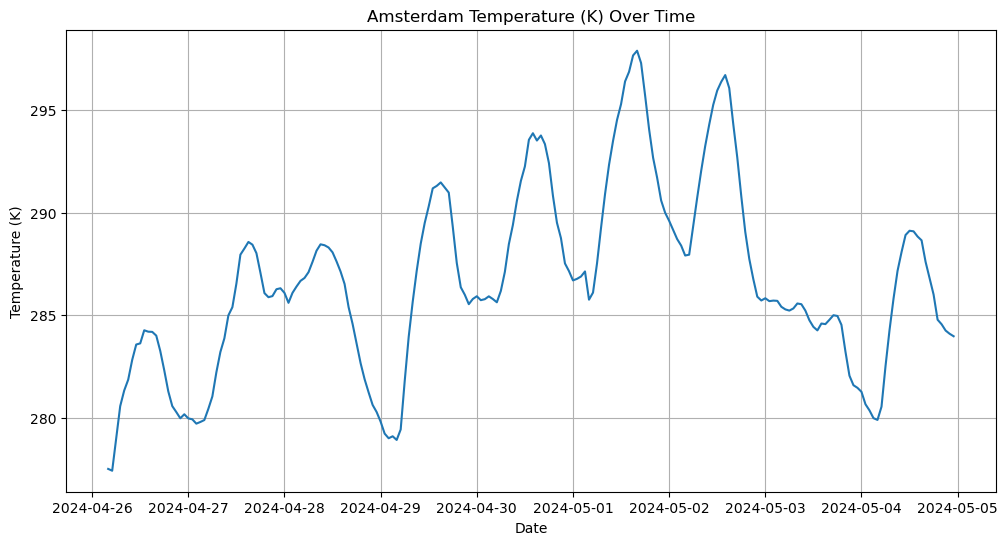

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(ams_ts.index, ams_ts['t2m'])
plt.title("Amsterdam Temperature (K) Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.grid(True)

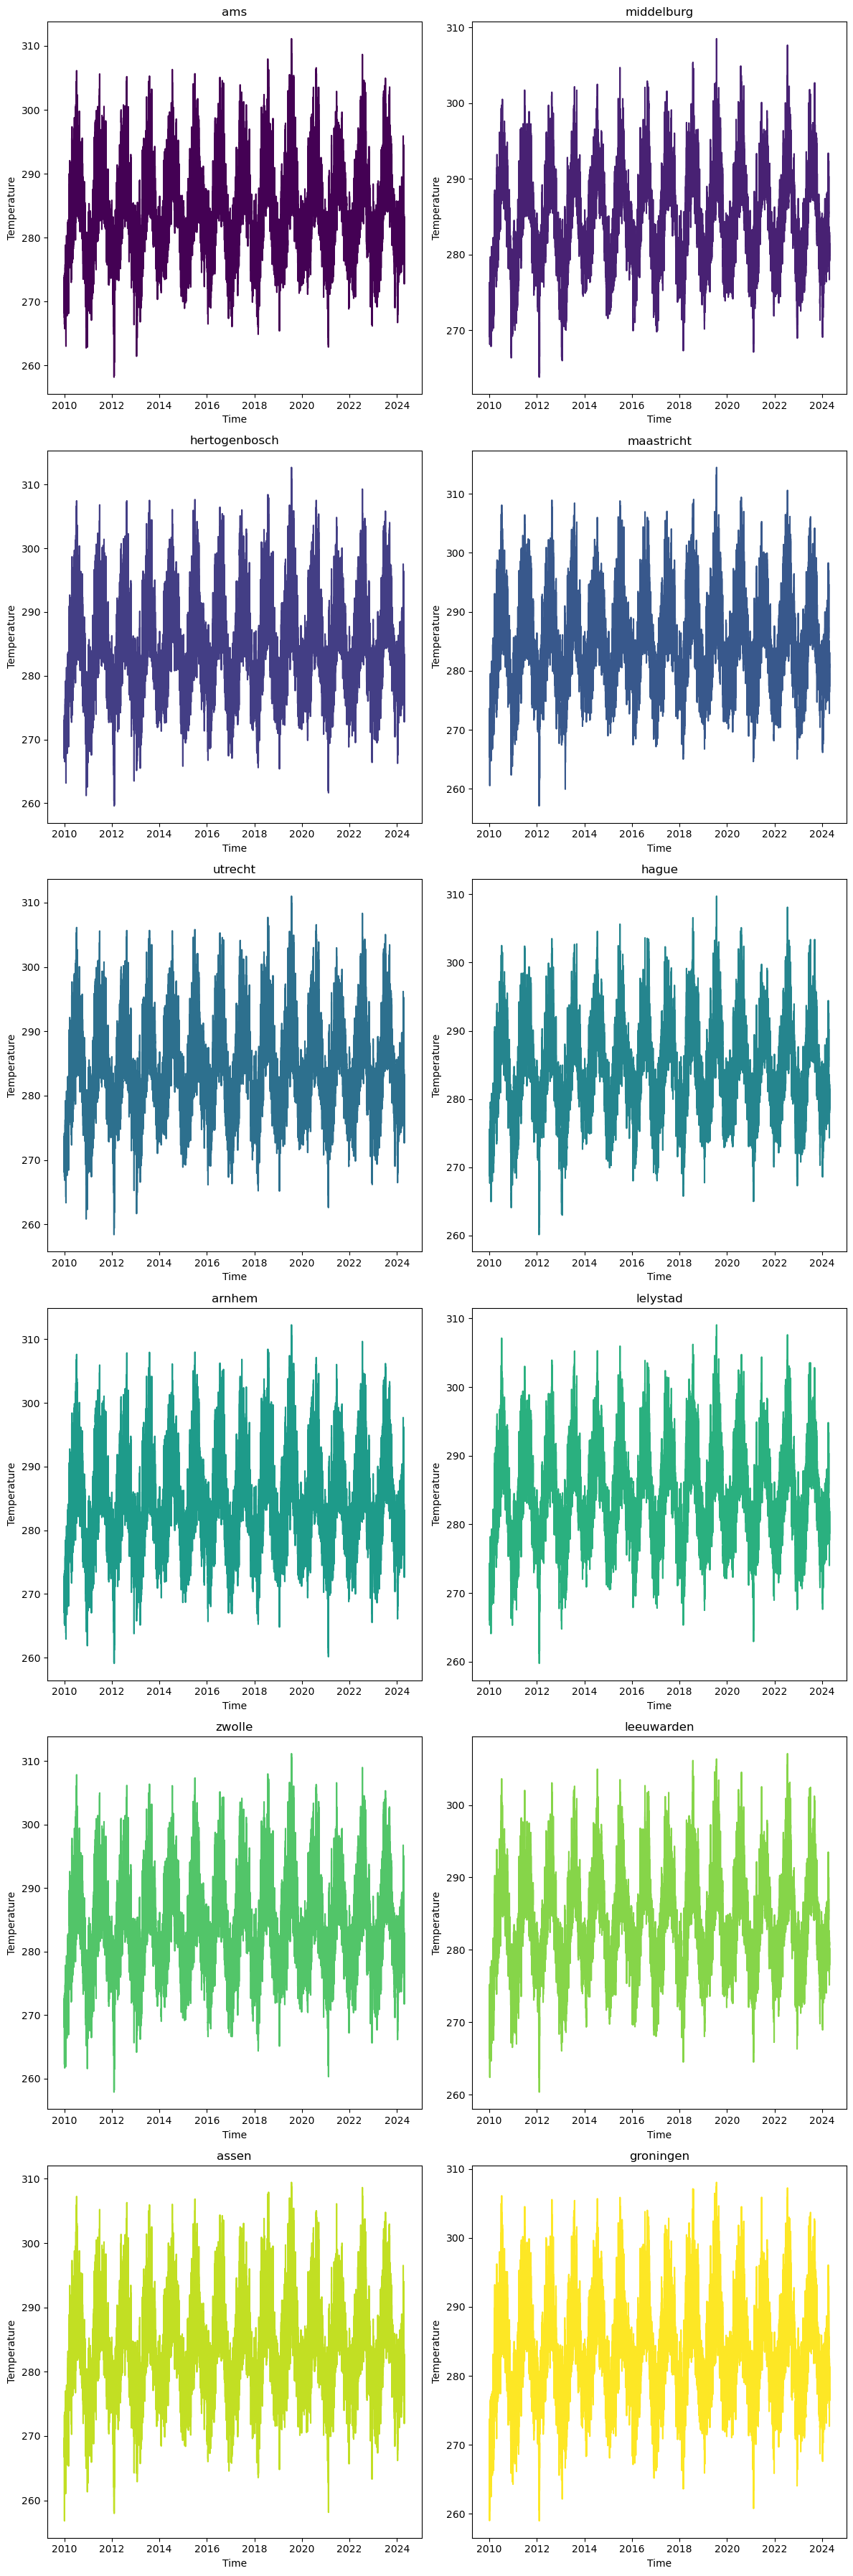

In [116]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Example: dataframes_tr = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_tr)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_tr, colors)):
    row = i // num_cols
    col = i % num_cols

    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city.index.dtype, np.datetime64):
        city.index = pd.to_datetime(city.index)

    axs[row, col].plot(city.index, city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

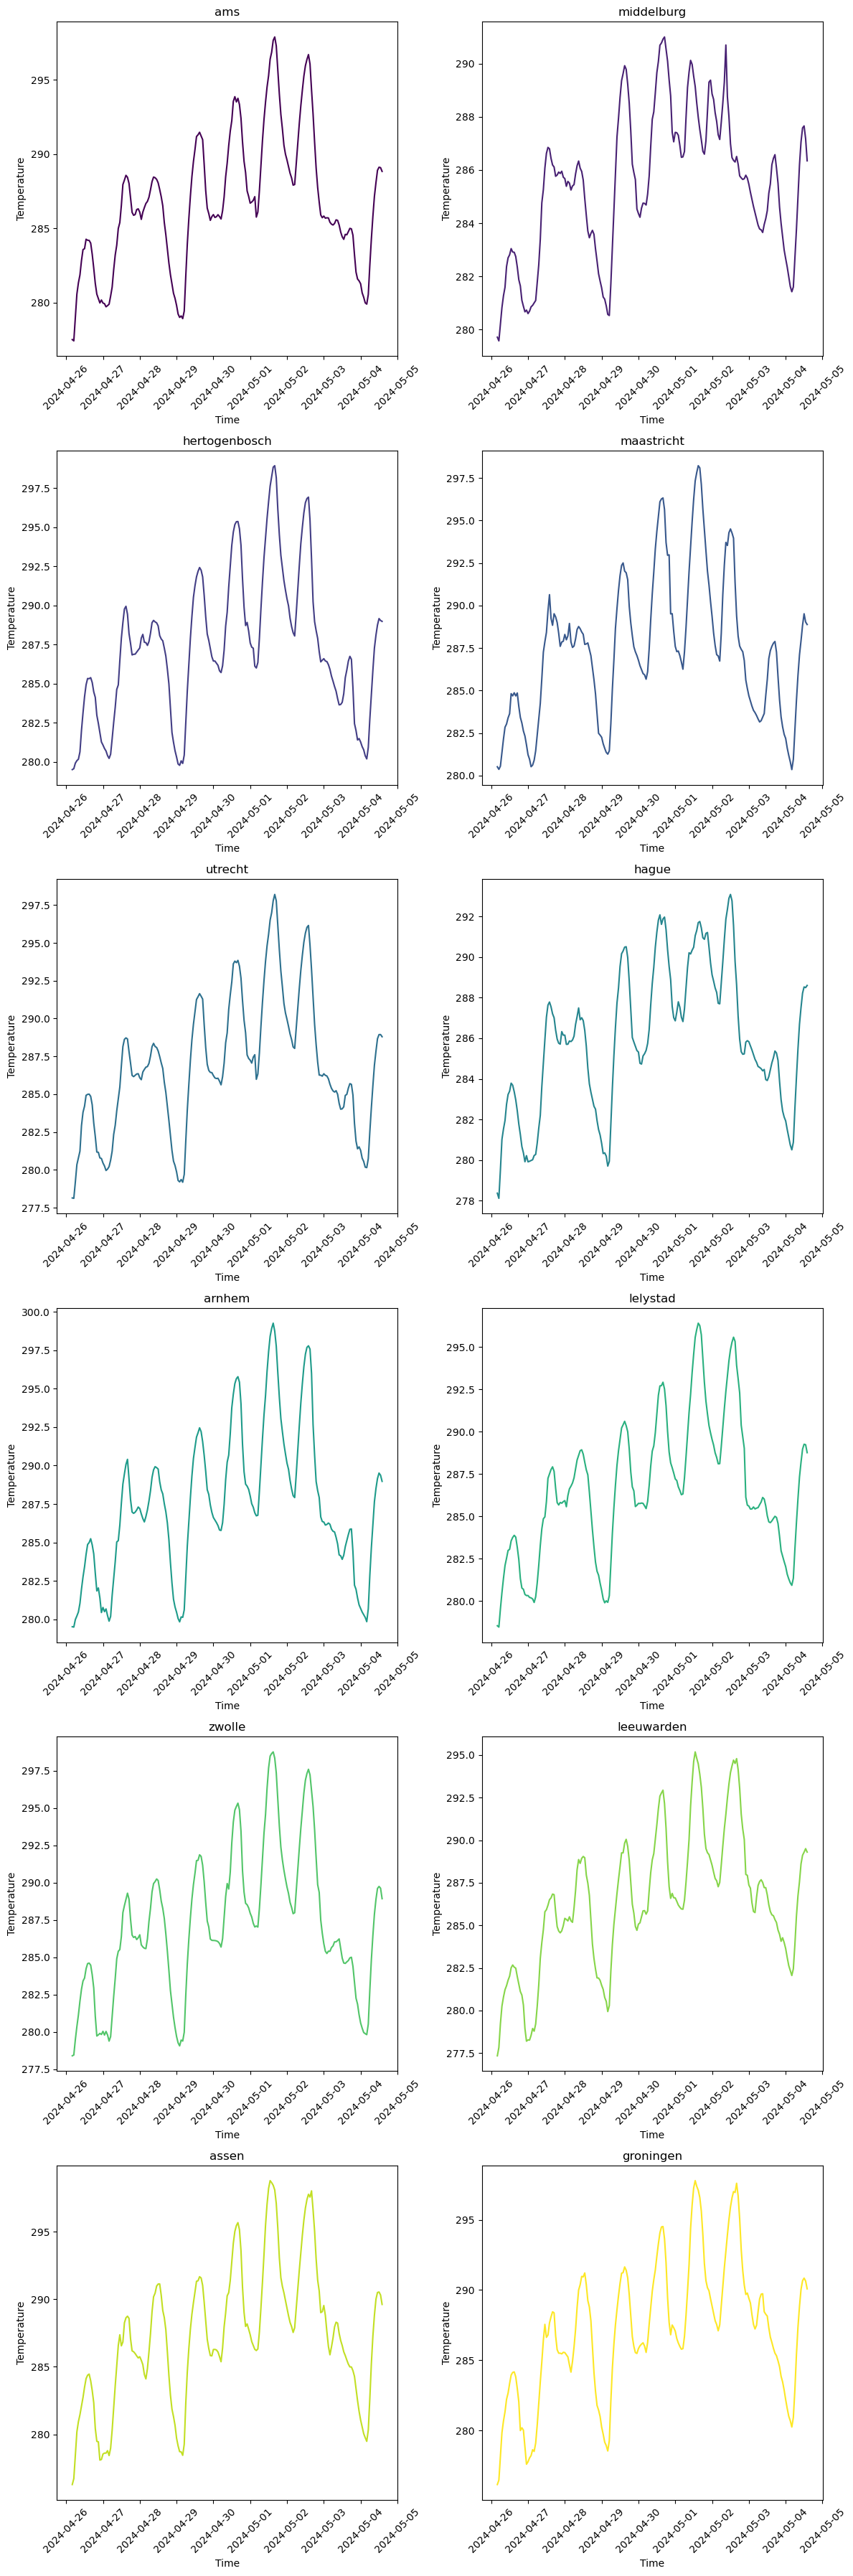

In [117]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Example: dataframes_ts = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_ts)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_ts, colors)):
    row = i // num_cols
    col = i % num_cols
    
    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city.index.dtype, np.datetime64):
        city.index = pd.to_datetime(city.index)
    
    axs[row, col].plot(city.index, city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')
    # Tilt the x-axis labels
    for tick in axs[row, col].get_xticklabels():
        tick.set_rotation(45)

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [14]:
X_test_df = {}
Y_test_df = {}

for i, city in enumerate(dataframes_ts):
    df = city.copy()

    X_test = df['t2m']
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_test = df['t2m']

    scaler = MinMaxScaler()
    X_test = X_test.values.reshape(-1, 1)
    X_test_scaled = scaler.fit_transform(X_test)
    Y_test = Y_test.values.reshape(-1, 1)
    Y_test_scaled = scaler.fit_transform(Y_test)

    X_test_tensor, Y_test_tensor = create_sequences(X_test_scaled, Y_test_scaled, timestep)

    X_test_df[df_names[i]] = X_test_tensor
    Y_test_df[df_names[i]] = Y_test_tensor

# 2 different approaches

- transfer learning

- separate models for each city

In [ ]:
i = 'ams'

# Define your tensorXtrain, tensorYtrain, tensorXvalid, tensorYvalid, tensorXtest, and scaledYtest here
tensorXtrain = X_train_df[i]
tensorYtrain = Y_train_df[i]
tensorXvalid = X_valid_df[i]
tensorYvalid = Y_valid_df[i]
tensorXtest = X_test_df[i]
Y_test = ams_ts['t2m']

# Train the model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(tensorXtrain.shape[1], tensorXtrain.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(tensorXtrain, tensorYtrain, epochs=200, batch_size=32, validation_data=(tensorXvalid, tensorYvalid), callbacks=[early_stopping])

Epoch 1/200


2024-06-21 12:20:53.927645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:54.403549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:54.480113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:55.620567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:55.636085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:57.009327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:57.024671: I tensorflow/core/grappler/optimizers/cust

3138/3138 [==============================] - ETA: 0s - loss: 0.0029

2024-06-21 12:22:58.808528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:58.978877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:59.013226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:59.870996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:59.882546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:23:01.011154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:23:01.023018: I tensorflow/core/grappler/optimizers/cust

3138/3138 [==============================] - 141s 40ms/step - loss: 0.0029 - val_loss: 5.1670e-04
Epoch 2/200
3138/3138 [==============================] - 121s 38ms/step - loss: 3.1874e-04 - val_loss: 6.3162e-04
Epoch 3/200
3138/3138 [==============================] - 115s 37ms/step - loss: 2.8449e-04 - val_loss: 3.7642e-04
Epoch 4/200
3138/3138 [==============================] - 116s 37ms/step - loss: 2.2252e-04 - val_loss: 4.7649e-04
Epoch 5/200
3138/3138 [==============================] - 116s 37ms/step - loss: 1.6864e-04 - val_loss: 3.7057e-04
Epoch 6/200
3138/3138 [==============================] - 117s 37ms/step - loss: 1.5564e-04 - val_loss: 3.8452e-04
Epoch 7/200
3138/3138 [==============================] - 117s 37ms/step - loss: 1.5293e-04 - val_loss: 3.9678e-04
Epoch 8/200
3138/3138 [==============================] - 115s 37ms/step - loss: 1.5155e-04 - val_loss: 4.5336e-04
Epoch 9/200
3138/3138 [==============================] - 115s 37ms/step - loss: 1.4720e-04 - val_loss: 2

In [15]:
Y_test = ams_ts['t2m']

In [18]:
model = load_model('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/Python/LSTM/models/ams')

In [35]:
dataframes_ts[0].index

Index([  2024-04-26 04:00:00,   2024-04-26 05:00:00,   2024-04-26 06:00:00,
         2024-04-26 07:00:00,   2024-04-26 08:00:00,   2024-04-26 09:00:00,
         2024-04-26 10:00:00,   2024-04-26 11:00:00,   2024-04-26 12:00:00,
         2024-04-26 13:00:00,
       ...
         2024-05-04 14:00:00, '2024-05-04 15:00:00', '2024-05-04 16:00:00',
       '2024-05-04 17:00:00', '2024-05-04 18:00:00', '2024-05-04 19:00:00',
       '2024-05-04 20:00:00', '2024-05-04 21:00:00', '2024-05-04 22:00:00',
       '2024-05-04 23:00:00'],
      dtype='object', name='time', length=212)

2024-06-24 12:19:08.137131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:08.292822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:08.303216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:09.175927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:09.186623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:10.369378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:10.380337: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 144ms/step


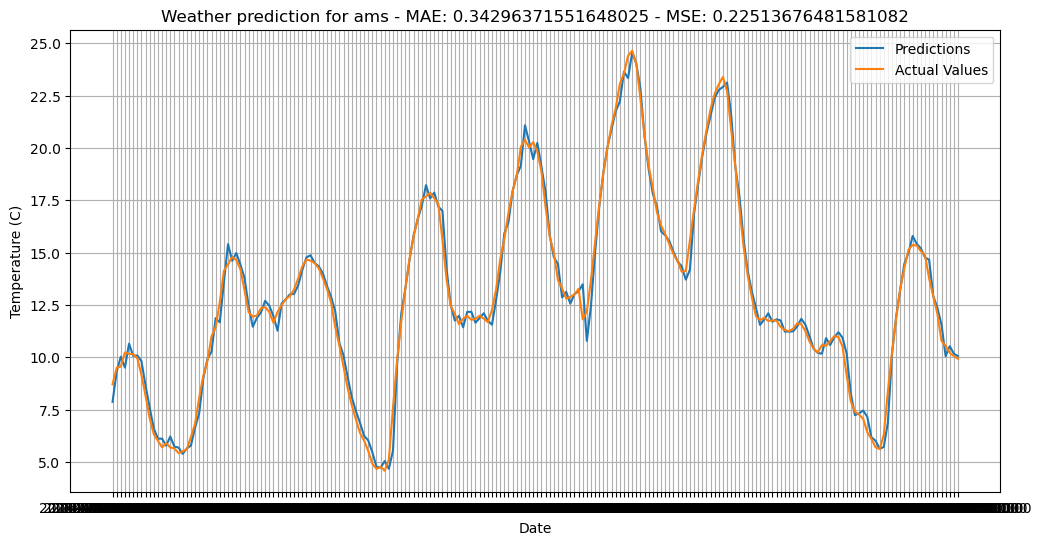

2024-06-24 12:19:17.032140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:17.185746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:17.196858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:18.052339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:18.064172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:19.209989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:19.221074: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 155ms/step


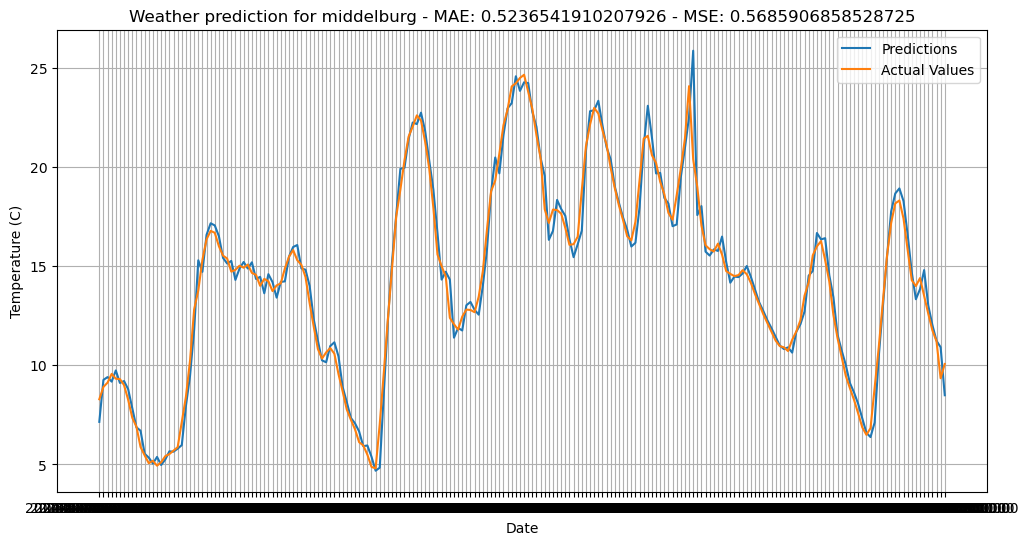

2024-06-24 12:19:26.110367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:26.271812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:26.282823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:27.162707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:27.173211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:28.364402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:28.375623: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 162ms/step


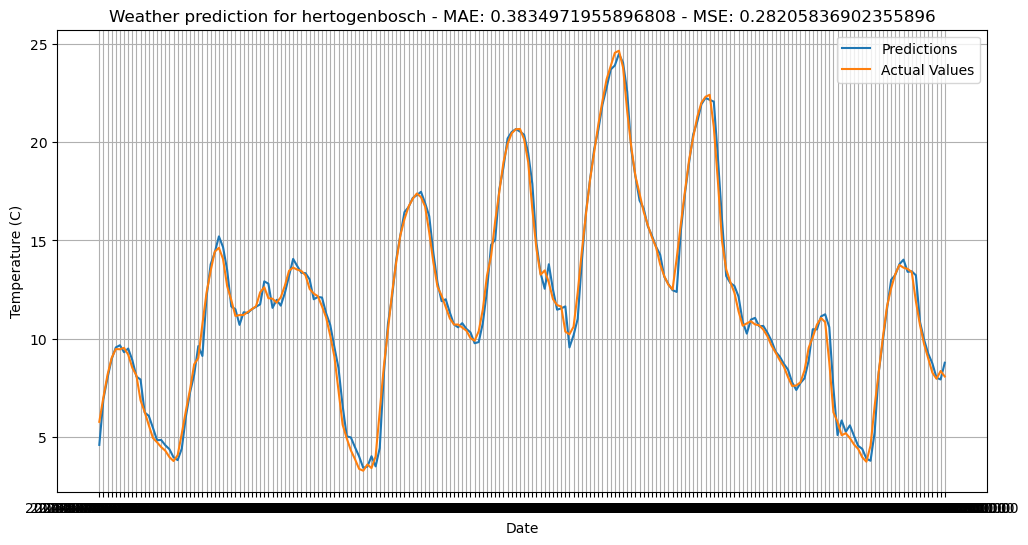

2024-06-24 12:19:35.342834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:35.502450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:35.513228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:36.405050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:36.417240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:37.673013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:37.688609: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 164ms/step


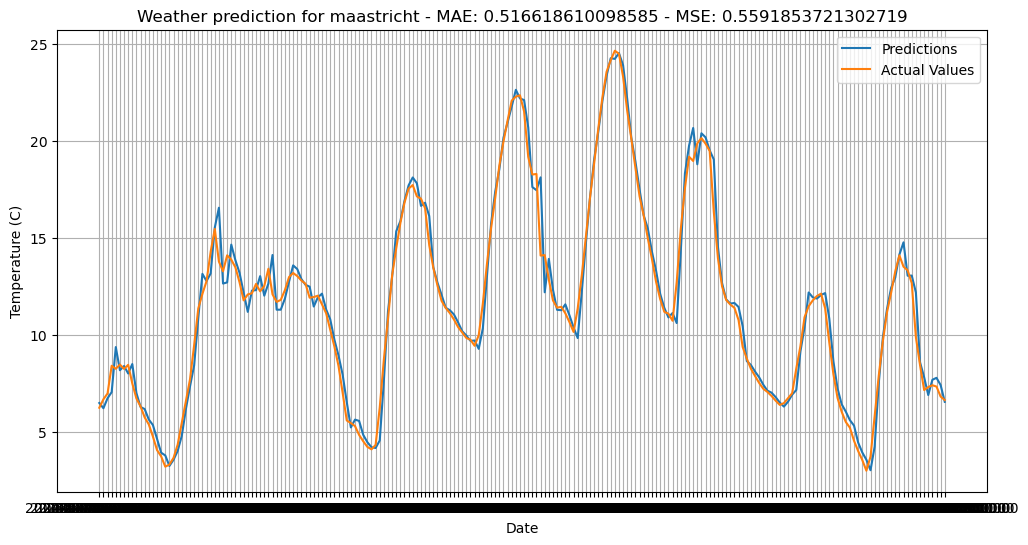

2024-06-24 12:19:44.712558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:44.869540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:44.880189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:45.764633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:45.775498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:46.968183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:46.979562: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 165ms/step


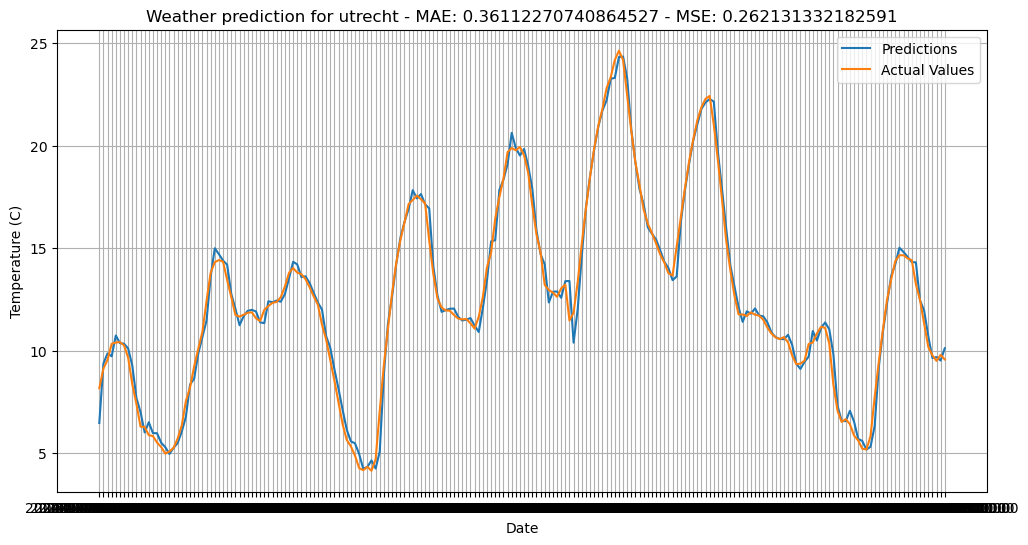

2024-06-24 12:19:54.124770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:54.284779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:54.296275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:55.218722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:55.230319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:56.518023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:19:56.530257: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 166ms/step


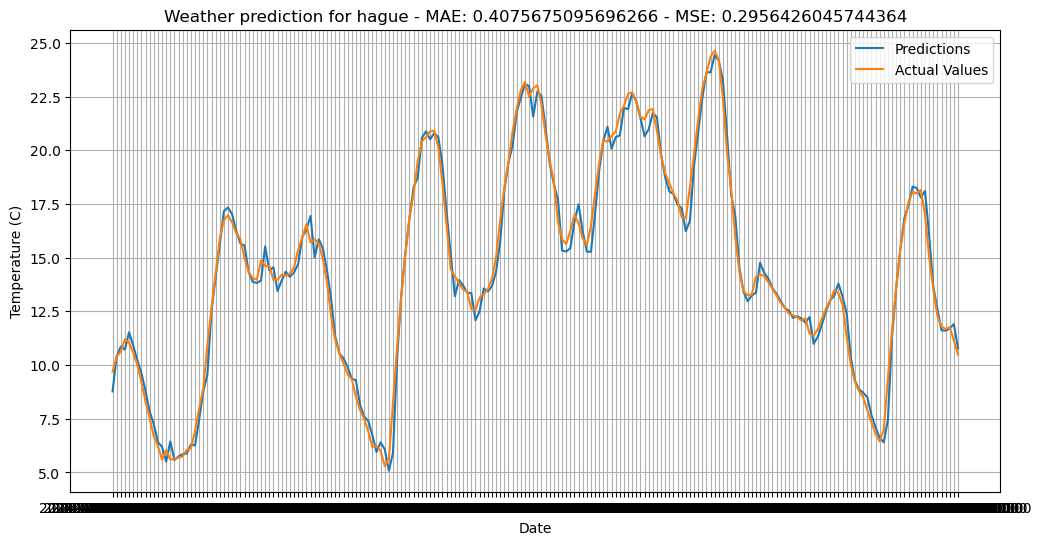

2024-06-24 12:20:03.805948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:03.972830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:03.983838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:04.912367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:04.923293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:06.186652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:06.198032: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 167ms/step


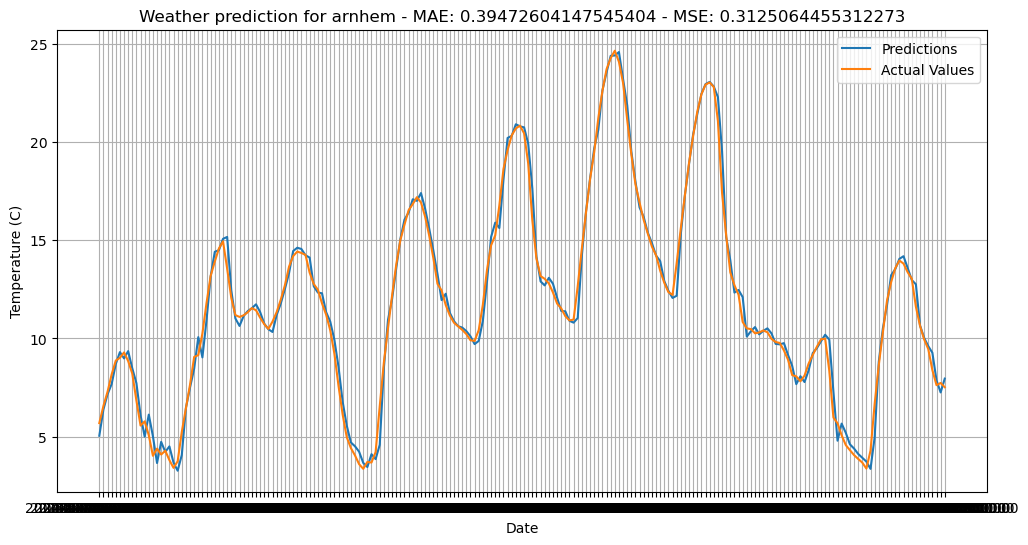

2024-06-24 12:20:13.426453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:13.587484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:13.598012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:14.525227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:14.536477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:15.841932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:15.853570: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 171ms/step


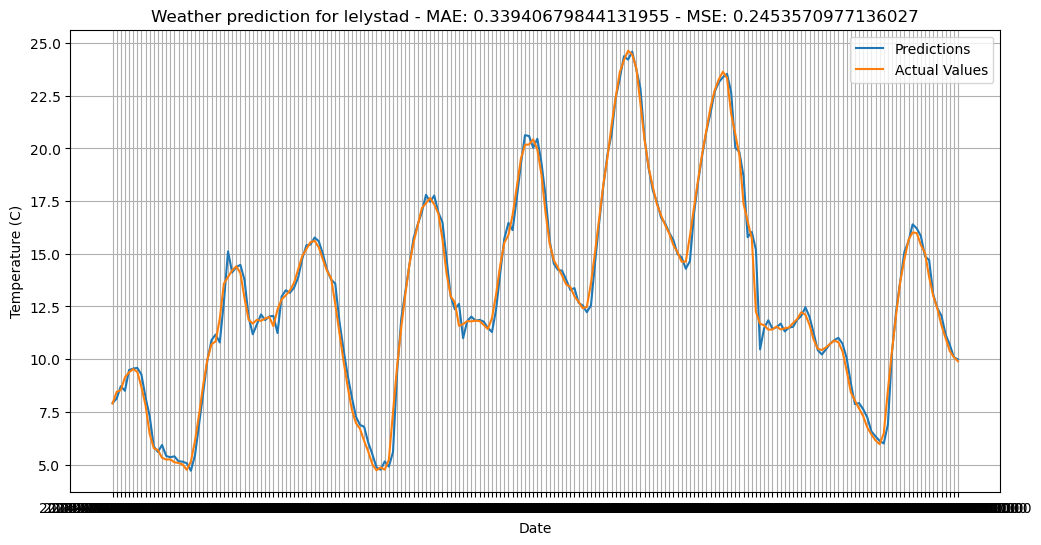

2024-06-24 12:20:23.240020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:23.401390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:23.411962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:24.351310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:24.362115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:25.627128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:25.638776: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 170ms/step


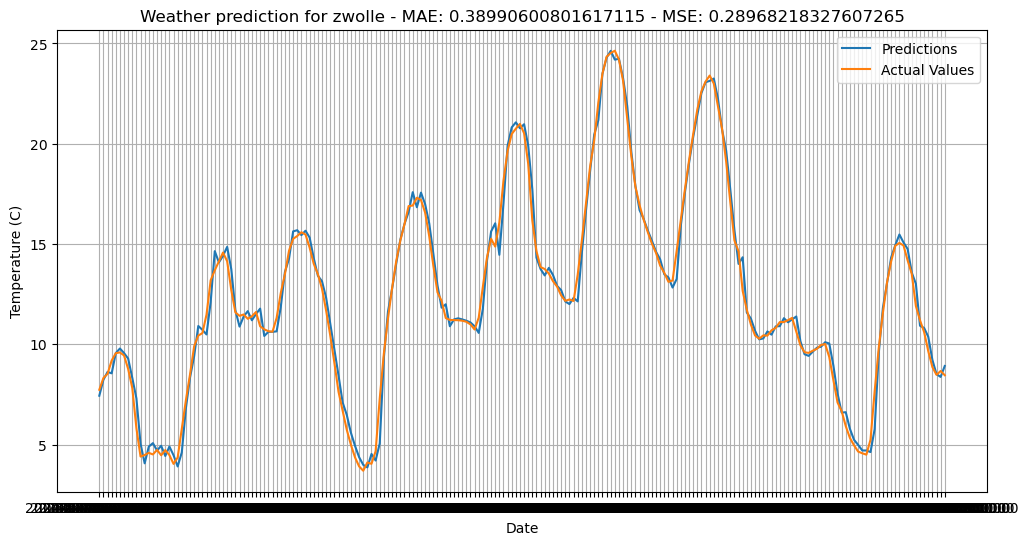

2024-06-24 12:20:48.395414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:48.560219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:48.571854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:49.502121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:49.513938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:50.775852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:50.791242: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 168ms/step


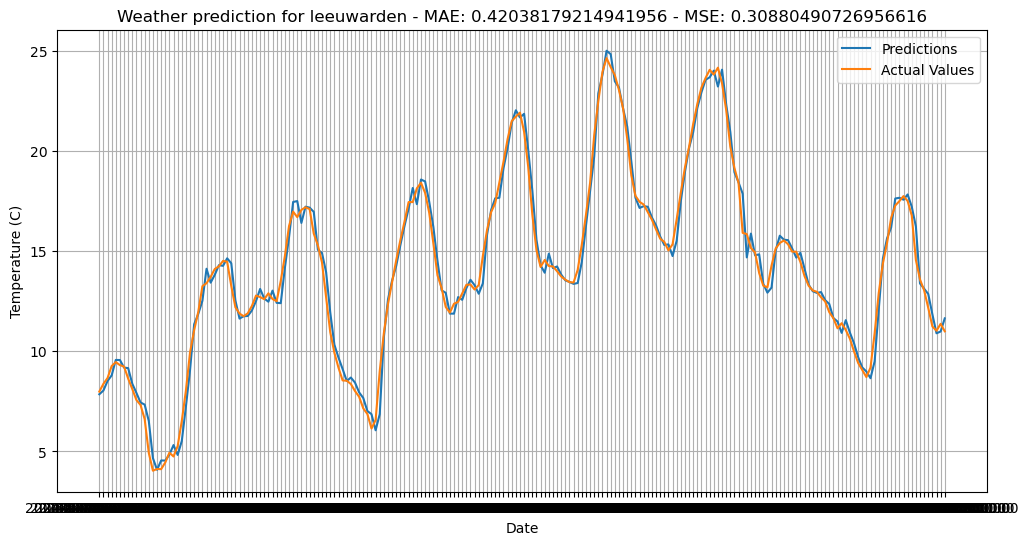

2024-06-24 12:20:57.825795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:57.984118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:57.995089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:58.930399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:20:58.941671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:00.221263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:00.232571: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 169ms/step


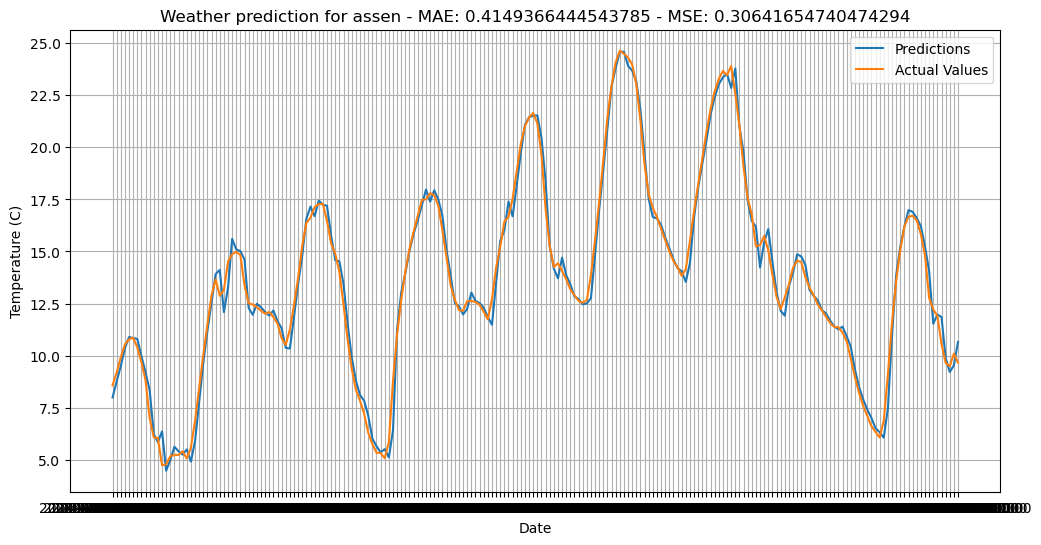

2024-06-24 12:21:07.437165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:07.604071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:07.615780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:08.647224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:08.659274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:09.957836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:21:09.969777: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 169ms/step


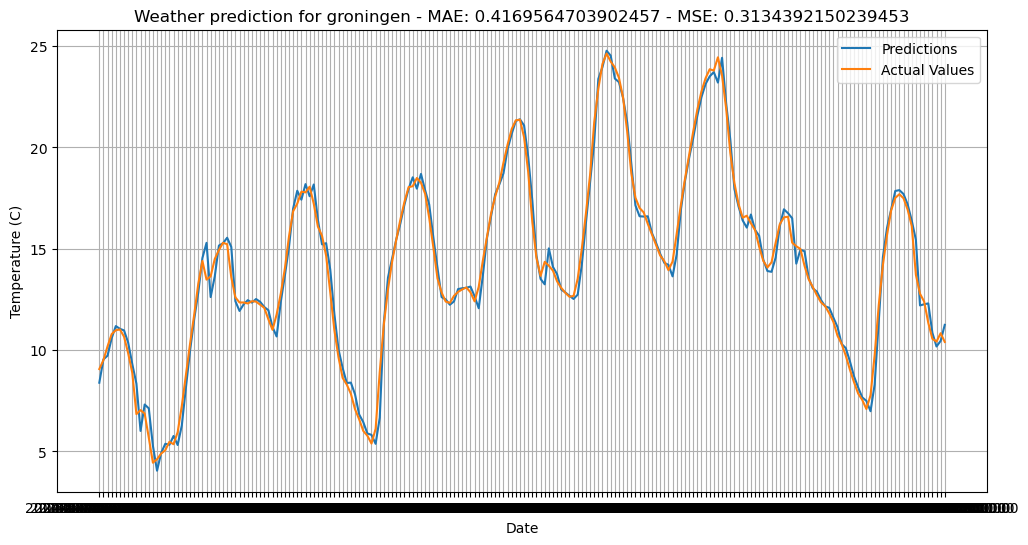

In [43]:
for idx, i in enumerate(df_names):
    model = load_model(f'/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/Python/LSTM/models/{i}')
    tensorXtest = X_test_df[i]
    Y_test = scaler.inverse_transform(Y_test_df[i])
    
    true_predict = scaler.inverse_transform(model.predict(tensorXtest))

    mae = mean_absolute_error(Y_test[-len(true_predict):], true_predict)
    mse = mean_squared_error(Y_test[-len(true_predict):], true_predict)

    plt.figure(figsize = (12, 6))
    plt.plot(dataframes_ts[0]['valid_time'][-len(true_predict):], true_predict - 273.15, label = "Predictions")
    plt.plot(Y_test[-len(true_predict):] - 273.15, label = "Actual Values")
    plt.title(f"Weather prediction for {i} - MAE: {mae} - MSE: {mse}")
    plt.ylabel("Temperature (C)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.show()

# transfer learning lstm

2024-06-24 12:29:34.851525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:29:35.015167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:29:35.025704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:29:36.047461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:29:36.058749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:29:37.451871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 12:29:37.464544: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 6s 180ms/step


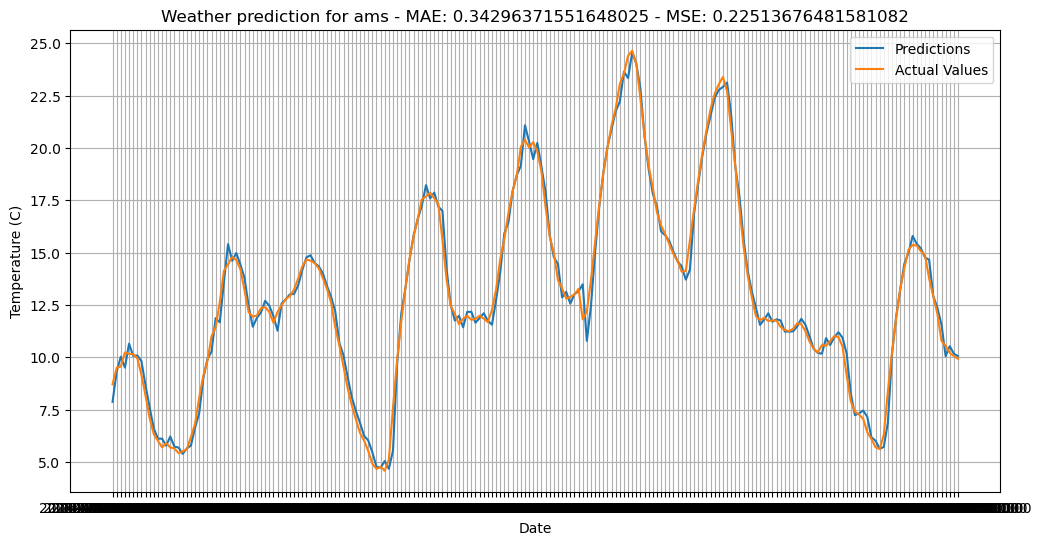

7/7 [==============================] - 0s 25ms/step


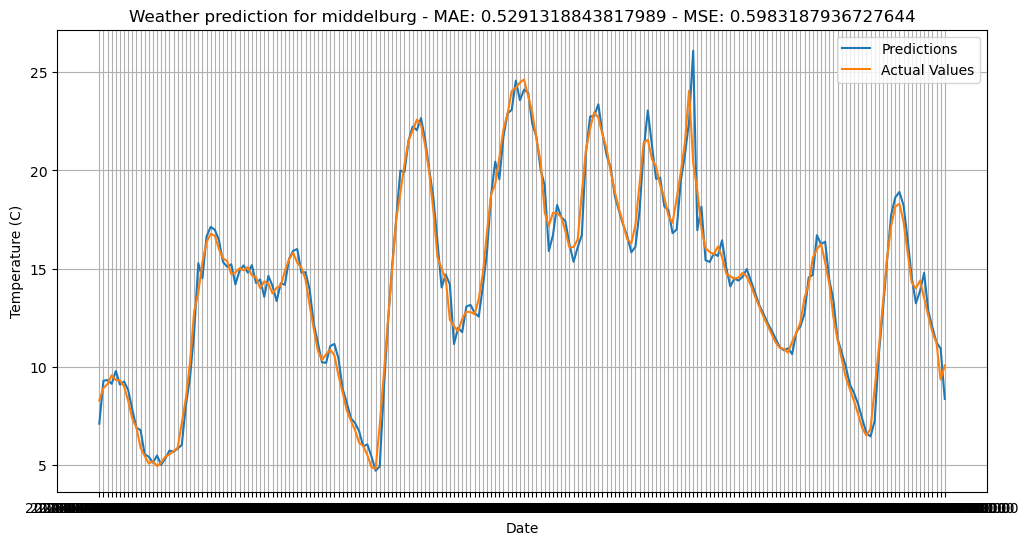

7/7 [==============================] - 0s 17ms/step


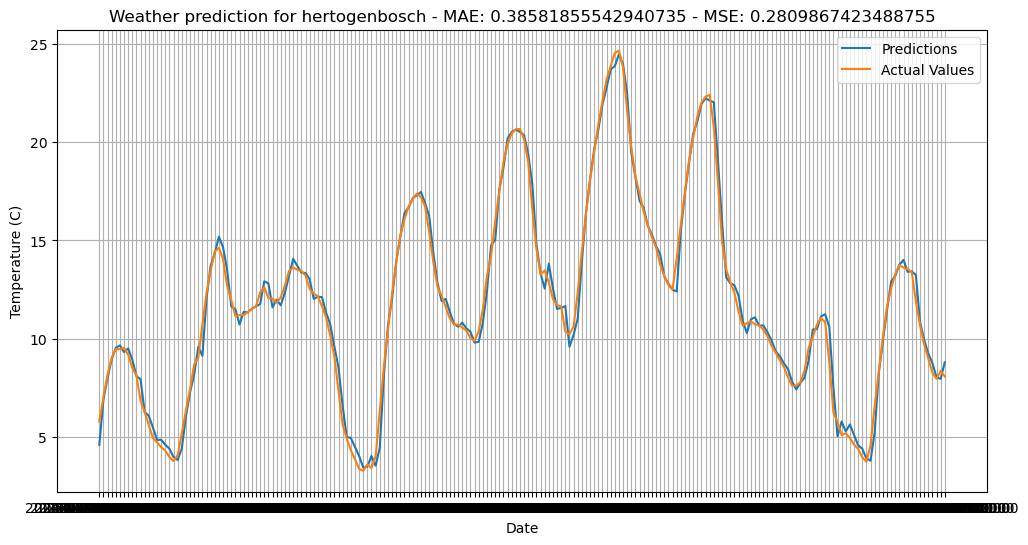

7/7 [==============================] - 0s 15ms/step


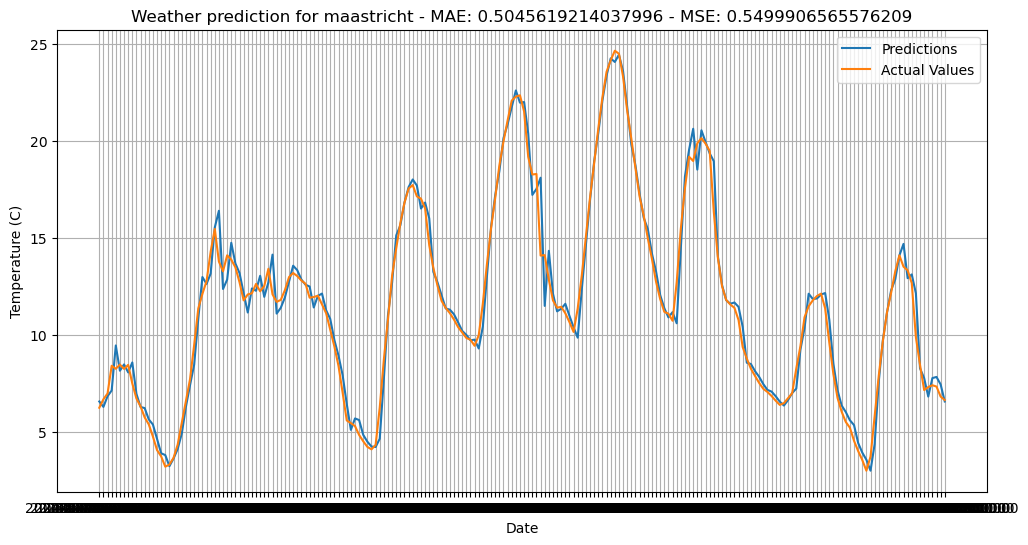

7/7 [==============================] - 0s 14ms/step


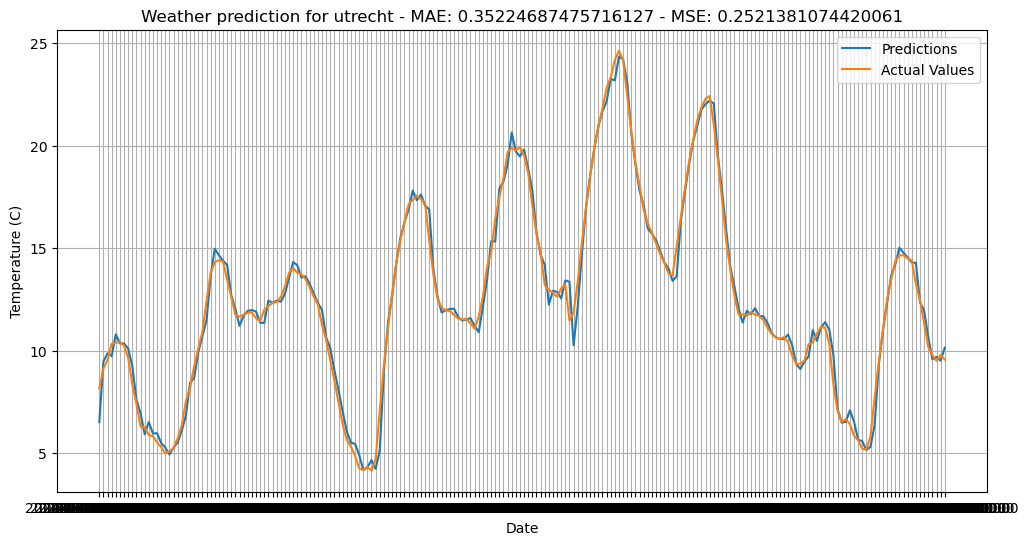

7/7 [==============================] - 0s 18ms/step


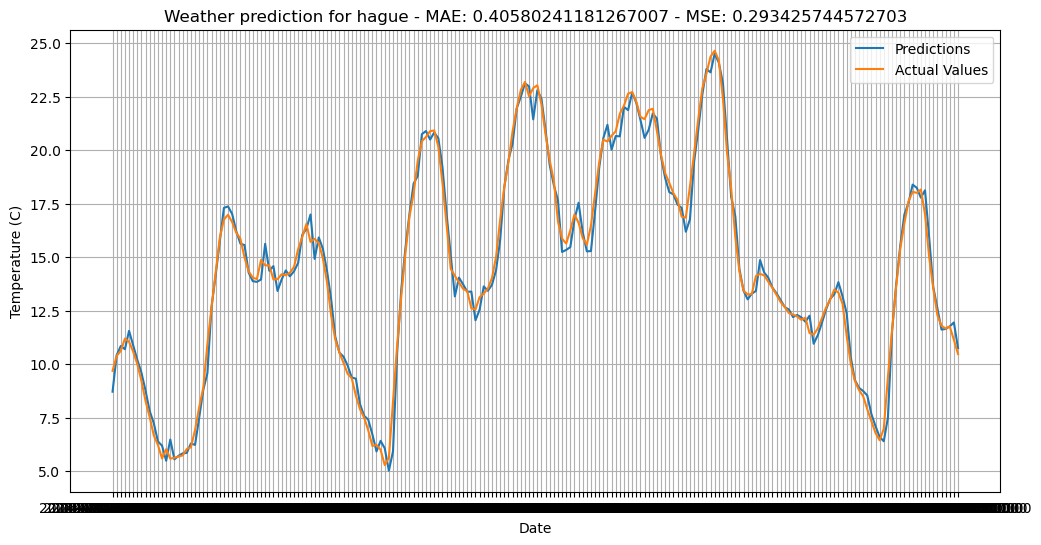

7/7 [==============================] - 0s 13ms/step


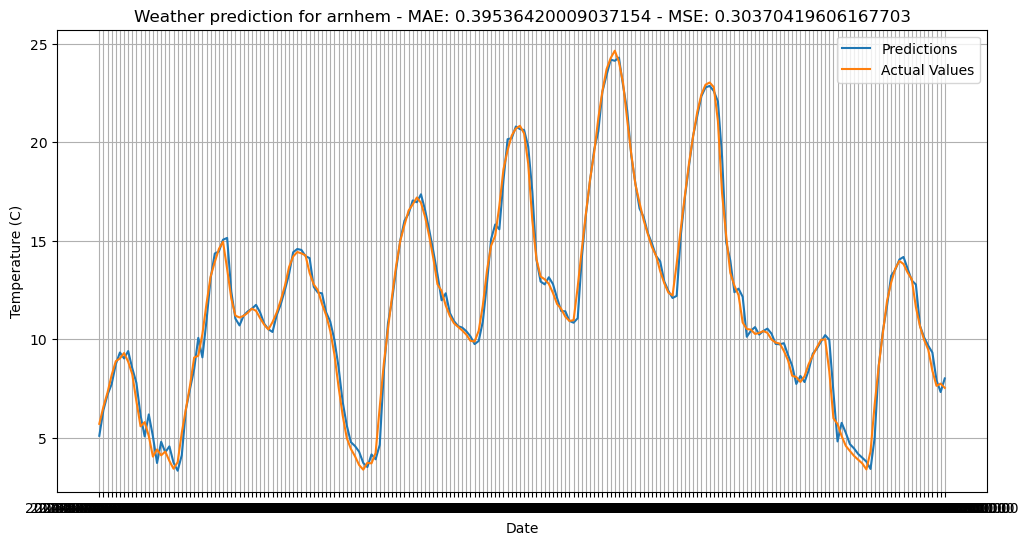

7/7 [==============================] - 0s 14ms/step


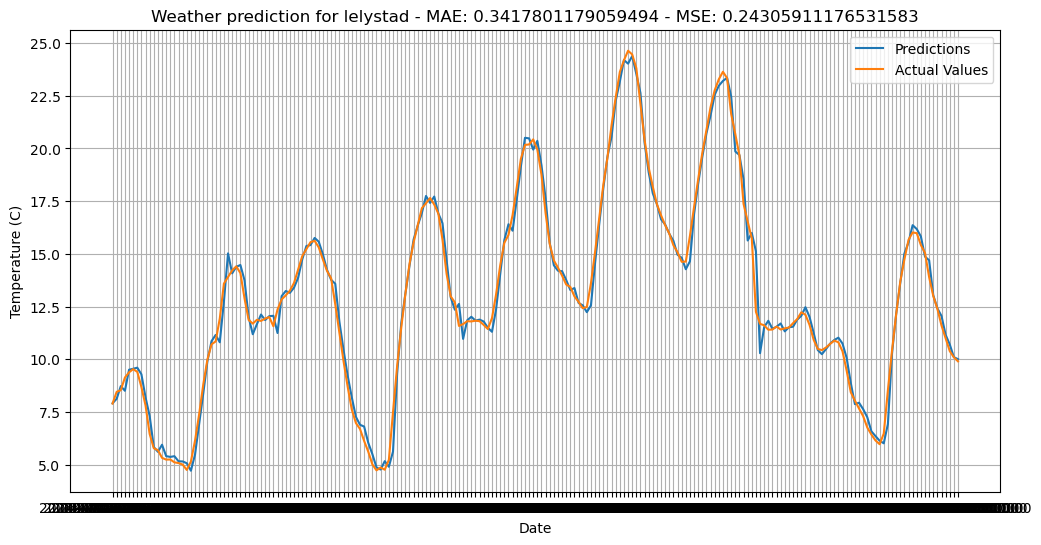

7/7 [==============================] - 0s 13ms/step


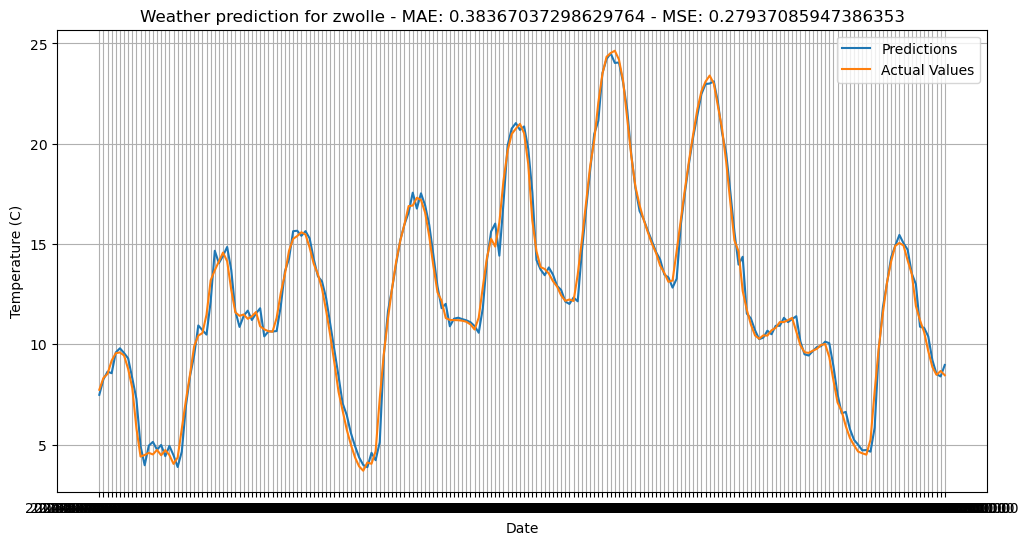

7/7 [==============================] - 0s 13ms/step


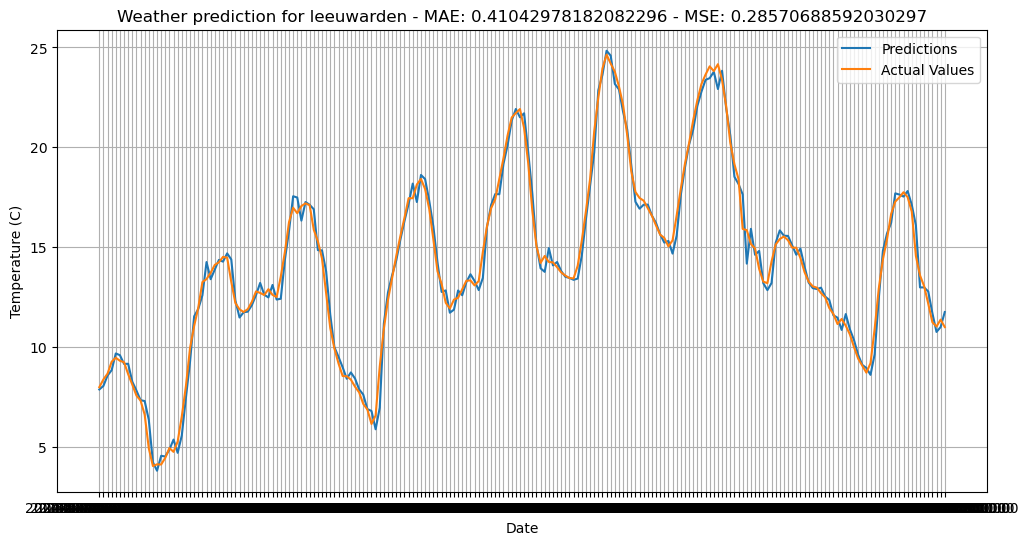

7/7 [==============================] - 0s 13ms/step


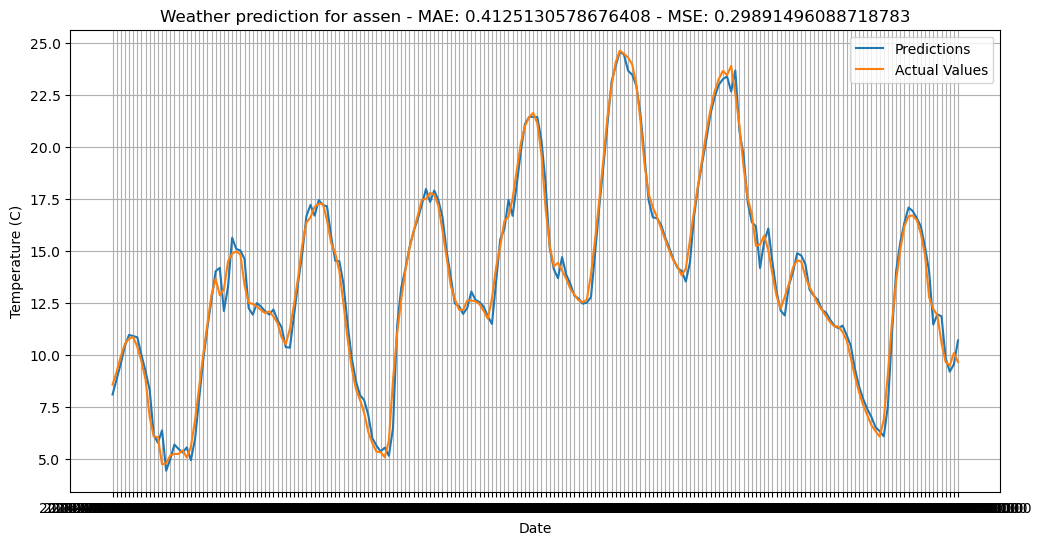

7/7 [==============================] - 0s 19ms/step


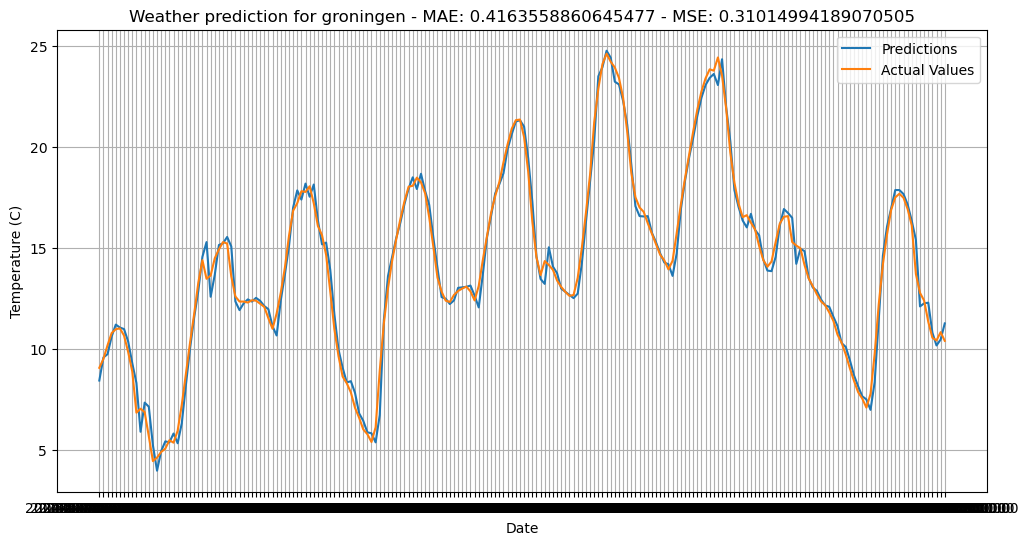

In [45]:
model = load_model('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/Python/LSTM/models/ams')

for idx, i in enumerate(df_names):
    tensorXtest = X_test_df[i]
    Y_test = scaler.inverse_transform(Y_test_df[i])
    
    true_predict = scaler.inverse_transform(model.predict(tensorXtest))

    mae = mean_absolute_error(Y_test[-len(true_predict):], true_predict)
    mse = mean_squared_error(Y_test[-len(true_predict):], true_predict)

    plt.figure(figsize = (12, 6))
    plt.plot(dataframes_ts[0]['valid_time'][-len(true_predict):], true_predict - 273.15, label = "Predictions")
    plt.plot(Y_test[-len(true_predict):] - 273.15, label = "Actual Values")
    plt.title(f"Weather prediction for {i} - MAE: {mae} - MSE: {mse}")
    plt.ylabel("Temperature (C)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.show()

# SHAP

# FORECAST

In [79]:
def multi_step_forecast(test_array, steps):
    forecast_values = []
    var_array = test_array # shift every iteration
    forecast_tensor = np.expand_dims(test_array, axis=0)  # add dim to array if single feature
    for i in range(steps):
        y_forecast = model.predict(forecast_tensor, verbose = False)
        forecast_values.append(y_forecast)
        var_array = np.concatenate((var_array[1:], y_forecast), axis = 0)
        forecast_tensor = np.expand_dims(var_array, axis = 0)
    forecast = [i[0][0] for i in forecast_values]
    return forecast

In [75]:
for idx, i in enumerate(df_names):
    model = load_model(f'/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/Python/LSTM/models/{i}')
    
    tensorXtest = X_test_df[i]
    Y_forecast = dataframes_forecast[idx]['t2m'].values

    forecast = multi_step_forecast(tensorXtest[-1], 72)
    
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    
    # mega = np.concatenate((Y_test.flatten(), forecast.flatten()), axis = 0)
    
    # mega_real = np.concatenate((Y_test.flatten(), Y_forecast.flatten()), axis = 0)

    plt.figure(figsize = (12, 6))
    plt.plot(forecast - 273.15, label = "FORECAST")
    # plt.plot(Y_test.values)
    plt.plot(Y_forecast[:len(forecast)] - 273.15, label = "ACTUAL VALUES")
    plt.grid(True)
    plt.legend()
    plt.ylabel("Degrees (K)")
    plt.xlabel("time step")
    plt.title("LSTM Forecast 72 Hours in The Future")
    plt.show()

ValueError: in user code:

    File "/Users/lpaggen/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/lpaggen/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/lpaggen/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/lpaggen/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/lpaggen/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/lpaggen/miniforge3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 6, 1), found shape=(None, 206, 6, 1)
